# Redback Example

In this notebook we look at how we can import and use models from the [redback package](https://github.com/nikhil-sarin/redback).

Note that the redback package is not installed as part of the default TDAstro installation. Users will need to manually install it via pip (e.g. `pip install redback`) in order to run this notebook.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from redback import model_library

from tdastro.astro_utils.passbands import PassbandGroup
from tdastro.math_nodes.np_random import NumpyRandomFunc
from tdastro.math_nodes.ra_dec_sampler import OpSimRADECSampler
from tdastro.obstable.opsim import OpSim
from tdastro.simulate import simulate_lightcurves
from tdastro.models.redback_models import RedbackWrapperModel
from tdastro.utils.plotting import plot_lightcurves

from tdastro import _TDASTRO_BASE_DATA_DIR

# Reset the matplotlib configuration
plt.rcParams.update(plt.rcParamsDefault)

No module named 'lalsimulation'
lalsimulation is not installed. Some EOS based models will not work. Please use bilby eos or pass your own EOS generation class to the model
13:09 bilby INFO    : Running bilby version: 2.6.0
13:09 redback INFO    : Running redback version: 1.12.1


## Load Data Files

We start by loading the files we will need for running the simulation: the OpSim database and the passband information. Both of these live in the `data/` directory in the root directory. Note that nothing in this directory is saved to github, so the files might have to be downloaded initially.

For Rubin, a large number of OpSims can be found at [https://s3df.slac.stanford.edu/data/rubin/sim-data/](https://s3df.slac.stanford.edu/data/rubin/sim-data/). You can download an OpSim manually or using the `from_url()` helper function:

> opsim_url = "https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.4/baseline/baseline_v3.4_10yrs.db"

> opsim_data = OpSim.from_url(opsim_url)

We only care about the observations in the OpSim in the filters we wish to simulate. So we use `OpSim.filter_rows()` to remove those rows that do not match.

In [2]:
# Choose which filters to simulate.
filters = ["g", "r", "i", "z"]

# Load the OpSim data.
opsim_db = OpSim.from_db(_TDASTRO_BASE_DATA_DIR / "opsim" / "baseline_v3.4_10yrs.db")
print(f"Loaded OpSim with {len(opsim_db)} rows.")

# Filter to only the rows that match the filters we want to simulate.
filter_mask = np.isin(opsim_db["filter"], filters)
opsim_db = opsim_db.filter_rows(filter_mask)

# Print the number of rows and time bounds after filtering.
t_min, t_max = opsim_db.time_bounds()
print(f"Filtered OpSim to {len(opsim_db)} rows and times [{t_min}, {t_max}]")

# Load the passband data for the griz filters only.
table_dir = _TDASTRO_BASE_DATA_DIR / "passbands" / "LSST"
passband_group = PassbandGroup.from_preset(
    preset="LSST",
    filters=filters,
    units="nm",
    trim_quantile=0.001,
    delta_wave=1,
    table_dir=table_dir,
)

Loaded OpSim with 2146797 rows.


2025-08-28 13:09:30,842 - INFO - Loading passbands from preset LSST
2025-08-28 13:09:30,842 - INFO - Data file /Users/jkubica/h/tdastro/data/passbands/LSST/LSST/u.dat already exists. Skipping download.
2025-08-28 13:09:30,843 - INFO - Loading passband from file: /Users/jkubica/h/tdastro/data/passbands/LSST/LSST/u.dat
2025-08-28 13:09:30,850 - INFO - Data file /Users/jkubica/h/tdastro/data/passbands/LSST/LSST/g.dat already exists. Skipping download.
2025-08-28 13:09:30,850 - INFO - Loading passband from file: /Users/jkubica/h/tdastro/data/passbands/LSST/LSST/g.dat
2025-08-28 13:09:30,855 - INFO - Data file /Users/jkubica/h/tdastro/data/passbands/LSST/LSST/r.dat already exists. Skipping download.
2025-08-28 13:09:30,856 - INFO - Loading passband from file: /Users/jkubica/h/tdastro/data/passbands/LSST/LSST/r.dat
2025-08-28 13:09:30,861 - INFO - Data file /Users/jkubica/h/tdastro/data/passbands/LSST/LSST/i.dat already exists. Skipping download.
2025-08-28 13:09:30,861 - INFO - Loading pass

Filtered OpSim to 1630613 rows and times [60796.00143922635, 64448.429406568604]


## Create the model

We want to create a model that uses the predefined redback model from its library. Redback offers an extensive collection of models that can be accessed by name. For a list see [here](https://redback.readthedocs.io/en/latest/models.html). For this example, we choose the "one_component_kilonova_model" model. We look up the model using the `redback.model_library.all_models_dict` dictionary.

Note that redback models are defined as functions. All parameters, such as redshift or ejecta mass, are passed into this function as keyword arguments. As we will see shortly, TDAstro handles the conversion of sampled parameters into keyword parameters behind the scenes.

In [3]:
rb_model = model_library.all_models_dict["one_component_kilonova_model"]

Next we create a wrapper `RedbackWrapperModel` which brings the redback model into the TDAstro API space. This wrapper handles everything from the interpretation of parameters to the conversion of units (redback and TDAstro use different default units).

As in other examples, we want to make the parameters dynamic to mirror a real simulation. Let's start by drawing:

  * The location (`RA`, `dec`) uniformly from the footprint of the survey.
  * The start time (`t0`) uniformly from the coverage of the survey.
  * The `redshift` uniformly from [0.0, 0.1]
  * The mass ejecta (`mej`) as a Gaussian with mean 0.05

For the rest of the parameters we will set as constants (though these could also use samplers):

  * Gray opacity (`kappa`) = 1
  * Temperature floor in K (`temperature_floor`) = 3000
  * Minimum initial velocity (`vej`) = 0.2

**Note**: Unlike the other `PhysicalModel` classes, we will not pass all parameters as keyword arguments. The `RedbackWrapperModel` constructor takes a dictionary of parameters needed for that model. The dictionary maps parameter name to its setter.

In [4]:
# Use an OpSim based sampler for position.
ra_dec_sampler = OpSimRADECSampler(
    opsim_db,
    radius=3.0,  # degrees
    node_label="ra_dec_sampler",
)

# Use a uniform sampler for the starting time (t0) of activity.
time_sampler = NumpyRandomFunc("uniform", low=t_min, high=t_max, node_label="time_sampler")

# Set the parameters that are needed by the redback model. Note that the first two are set
# from samplers, while the last three are fixed values.
parameters = {
    "mej": NumpyRandomFunc("normal", loc=0.05, scale=0.02),
    "redshift": NumpyRandomFunc("uniform", low=0.0, high=0.1),
    "temperature_floor": 3000,
    "kappa": 1,
    "vej": 0.2,
}

# Create the model itself.
source = RedbackWrapperModel(
    rb_model,
    parameters=parameters,  # Set ALL the redback model parameters
    ra=ra_dec_sampler.ra,  # Set other parameters
    dec=ra_dec_sampler.dec,
    t0=time_sampler,
    node_label="source",
)

## Generate the simulations

We can now generate random simulations with all the information defined above. The `simulate_lightcurves` function takes four parameters: the source from which we want to sample (here the collection of lightcurves), the number of results to simulate (1,000), the opsim, and the passband information.

In [5]:
lightcurves = simulate_lightcurves(source, 1_000, opsim_db, passband_group)

The results are written in the [nested-pandas](https://github.com/lincc-frameworks/nested-pandas) format for easy analysis. Each row corresponds to a single simulated object, with a unique id, ra, dec, etc. The column `params` include all internal state, including hyperparameter settings, that was used to generate this object. The nested `lightcurve` column contains the times, filters, and fluxes for each observation of that object.  We can treat it as a (nested) table.

Let's look at the lightcurve for the first object sampled:

In [6]:
print(lightcurves.loc[0]["lightcurve"])

              mjd filter        flux     fluxerr  flux_perfect
0    60796.149970      g  -91.674022   61.979371     -6.237851
1    60797.131903      g -174.383157   77.540609     -6.234711
..            ...    ...         ...         ...           ...
682  64445.173455      z   56.439671  330.440636    555.249917
683  64445.184729      z  355.311396  350.216527    555.246443

[684 rows x 5 columns]


Now let's plot the first few lightcurves to see what they look like when observed via Rubin's cadence.

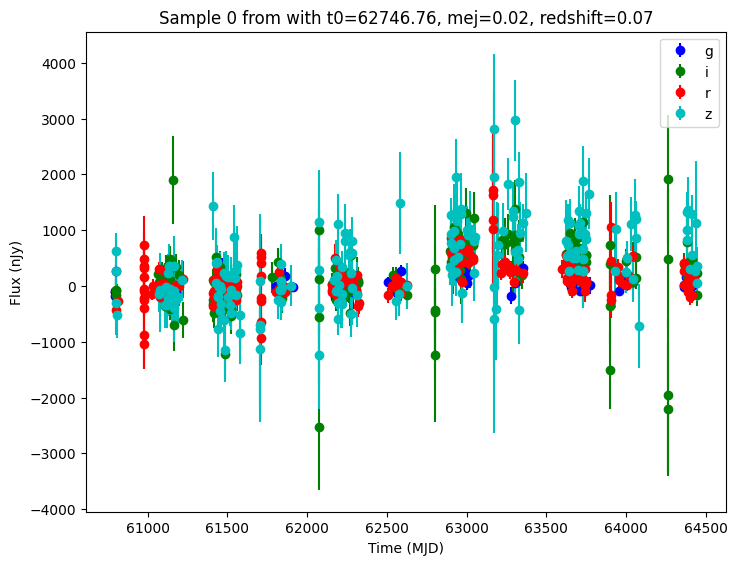

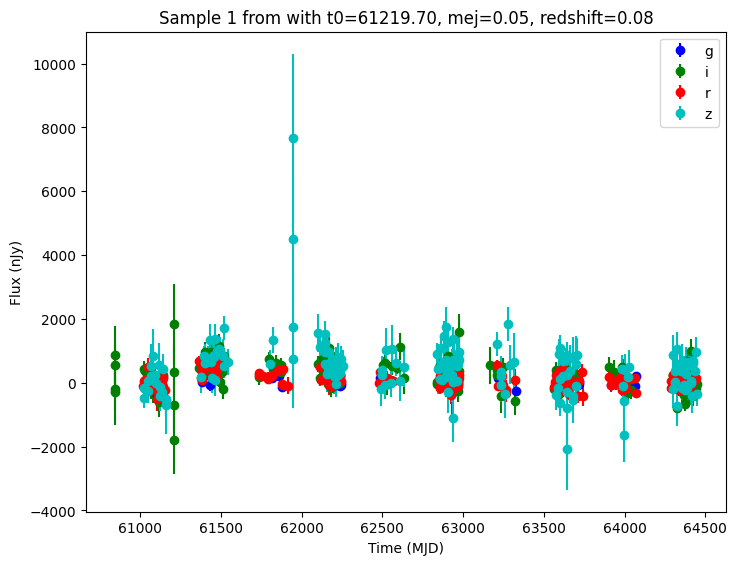

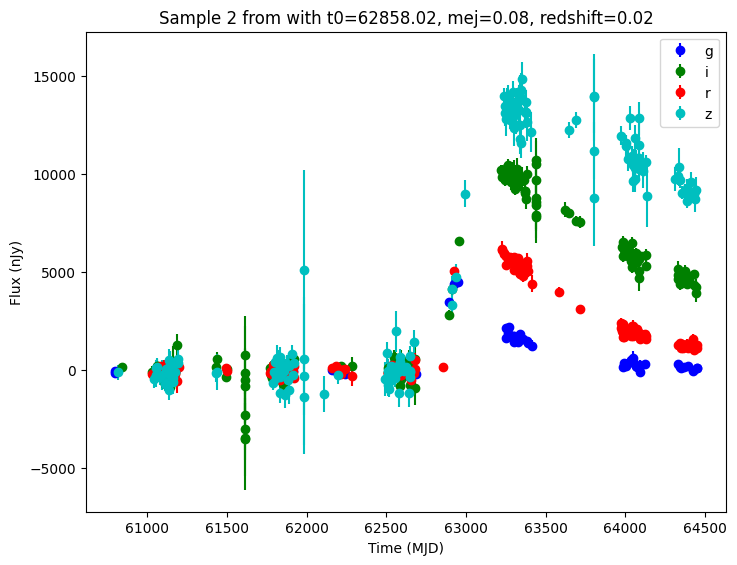

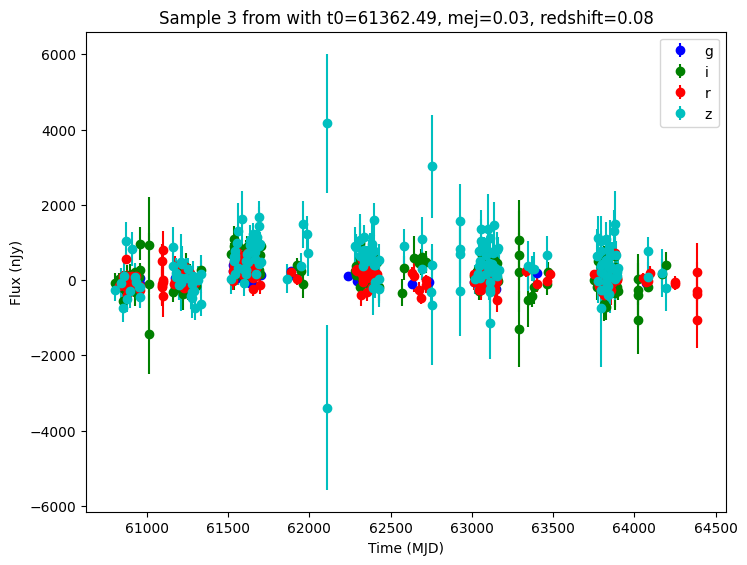

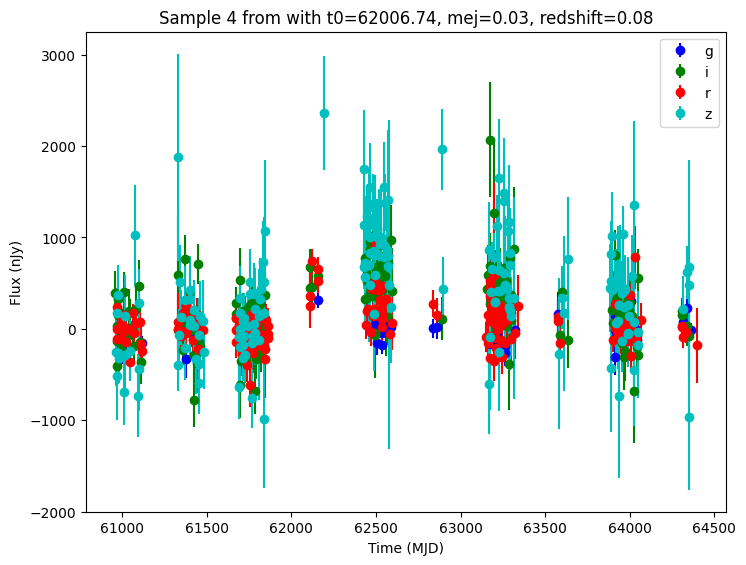

In [7]:
for idx in range(5):
    # Extract the row for this object.
    lc = lightcurves.loc[idx]

    if lc["nobs"] == 0:
        continue

    # Unpack the nested columns (filters, mjd, flux, and flux error).
    lc_filters = np.asarray(lc["lightcurve"]["filter"], dtype=str)
    lc_mjd = np.asarray(lc["lightcurve"]["mjd"], dtype=float)
    lc_flux = np.asarray(lc["lightcurve"]["flux"], dtype=float)
    lc_fluxerr = np.asarray(lc["lightcurve"]["fluxerr"], dtype=float)

    # Get information about the sampled parameter values for the plot's title.
    t0 = lc["params"]["source.t0"]
    mej = lc["params"]["source.mej"]
    redshift = lc["params"]["source.redshift"]

    # Plot the lightcurves.
    plot_lightcurves(
        fluxes=lc_flux,
        times=lc_mjd,
        fluxerrs=lc_fluxerr,
        filters=lc_filters,
        title=f"Sample {idx} from with t0={t0:.2f}, mej={mej:.2f}, redshift={redshift:.2f}",
    )